# Churn Prediction for a Music Streaming Service

## Problem Setup

We address the problem of predicting user churn in a music streaming platform. A user is defined as churned if they trigger a "Cancellation Confirmation" event within a 10-day observation window following a temporal cutoff. The prediction task is framed as binary classification: given a user's historical event sequence up to the cutoff date, we predict whether they will churn in the subsequent period.

This task presents several challenges. First, the raw data consists of behavioral event logs rather than pre-aggregated features, requiring us to engineer meaningful representations from variable-length sequences. Second, the temporal structure introduces leakage risk: naive feature construction could inadvertently encode information about the target event itself. Third, class imbalance is present, as churned users constitute a minority of the population. We address these challenges through careful temporal cutoffs, explicit removal of leaky pages, and appropriate modeling choices.


In [57]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
np.random.seed(42)


In [61]:
# Configuration
TRAIN_PATH = 'train.parquet'
TEST_PATH = 'test.parquet'

TRAIN_CUTOFF = pd.Timestamp('2018-11-10')  # cutoff for training features
FINAL_CUTOFF = pd.Timestamp('2018-11-20')  # cutoff for test features

LEAKY_PAGES = ['Cancellation Confirmation']  # pages that leak the target
CHURN_PAGE = 'Cancellation Confirmation'     # event defining churn

SEED = 42
CV_FOLDS = 10

LGB_PARAMS = {
    'n_estimators': 400,
    'learning_rate': 0.02,
    'max_depth': 7,
    'num_leaves': 40,
    'subsample': 0.65,
    'colsample_bytree': 0.65,
    'min_child_samples': 40,
    'reg_alpha': 2.0,
    'reg_lambda': 2.0,
    'class_weight': 'balanced',
    'verbose': -1
}


## 1. Data Loading and Exploratory Analysis

We begin by loading the training and test datasets. Each row in the data represents a single user event, such as playing a song, visiting a page, or interacting with the interface. The training set is used both for feature engineering and label construction, while the test set is used only for generating final predictions.


In [64]:
def load_data():
    train = pd.read_parquet(TRAIN_PATH)
    test = pd.read_parquet(TEST_PATH)
    return train, test

train_df, test_df = load_data()

print('Train: {} events, {} users'.format(len(train_df), train_df['userId'].nunique()))
print('Test: {} events, {} users'.format(len(test_df), test_df['userId'].nunique()))


Train: 17499636 events, 19140 users
Test: 4393179 events, 2904 users


In [65]:
train_df.head()


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21
992,200,M,Shlok,paid,Johnson,1749042,1538352525000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",279,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,178.02404,Monster (Album Version),Skillet,2018-10-01 00:08:45,2018-08-08 13:22:21
1360,200,M,Shlok,paid,Johnson,1749042,1538352703000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",280,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,232.61995,Seven Nation Army,The White Stripes,2018-10-01 00:11:43,2018-08-08 13:22:21
1825,200,M,Shlok,paid,Johnson,1749042,1538352935000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",281,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,265.50812,Under The Bridge (Album Version),Red Hot Chili Peppers,2018-10-01 00:15:35,2018-08-08 13:22:21
2366,200,M,Shlok,paid,Johnson,1749042,1538353200000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",282,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,471.69261,Circlesong 6,Bobby McFerrin,2018-10-01 00:20:00,2018-08-08 13:22:21


In [66]:
# Time coverage
print('Time range: {} to {}'.format(train_df['time'].min(), train_df['time'].max()))
print('Span: {} days'.format((train_df['time'].max() - train_df['time'].min()).days))


Time range: 2018-10-01 00:00:01 to 2018-11-20 00:00:00
Span: 49 days


In [67]:
# Target distribution
churned_users = set(train_df[train_df['page'] == CHURN_PAGE]['userId'].unique())
all_users = train_df['userId'].unique()

n_churned = len(churned_users)
n_total = len(all_users)
churn_rate = n_churned / n_total * 100

print('Total users: {}'.format(n_total))
print('Churned users: {} ({:.2f}%)'.format(n_churned, churn_rate))
print('Retained users: {} ({:.2f}%)'.format(n_total - n_churned, 100 - churn_rate))


Total users: 19140
Churned users: 4271 (22.31%)
Retained users: 14869 (77.69%)


In [68]:
# Page types (excluding events after cutoff to avoid temporal leakage in EDA)
df_before_cutoff = train_df[train_df['time'] <= TRAIN_CUTOFF]
page_counts = df_before_cutoff['page'].value_counts().head(15)
print('Top 15 page types (before cutoff):')
page_counts


Top 15 page types (before cutoff):


page
NextSong           11805692
Thumbs Up            650330
Home                 537360
Add to Playlist      337873
Roll Advert          251539
Add Friend           217169
Logout               170870
Thumbs Down          137197
Downgrade            101404
Settings              83835
Help                  73743
Upgrade               33325
About                 27490
Save Settings         16865
Error                 14333
Name: count, dtype: int64

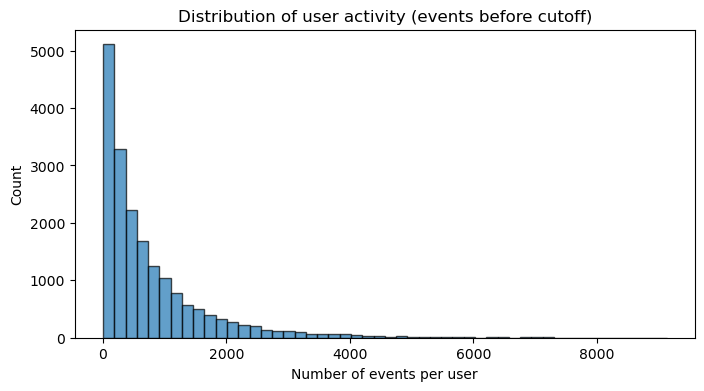

Events per user: mean=767.0, median=447.0, max=9127


In [69]:
events_per_user = df_before_cutoff.groupby('userId').size()

plt.figure(figsize=(8, 4))
plt.hist(events_per_user, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of events per user')
plt.ylabel('Count')
plt.title('Distribution of user activity (events before cutoff)')
plt.show()

print('Events per user: mean={:.1f}, median={:.1f}, max={}'.format(
    events_per_user.mean(), events_per_user.median(), events_per_user.max()))


## 2. Methodology: Time-Aware Dataset Construction

Converting raw event logs into supervised learning examples requires careful temporal reasoning. We define two key cutoff dates:

- **Training cutoff (2018-11-10)**: Features for the training set are computed using only events on or before this date. The label is determined by whether a user has any "Cancellation Confirmation" event in the full dataset.
- **Test cutoff (2018-11-20)**: Features for the test set are computed using only events on or before this date.

This temporal split prevents future information from leaking into the features. Additionally, we explicitly exclude the "Cancellation Confirmation" page from feature computation, as its presence would trivially reveal the target.



In [71]:
def build_labels(df):
    """
    Build binary churn labels from event data.
    A user is churned if they have any 'Cancellation Confirmation' event.
    """
    churned = set(df[df['page'] == CHURN_PAGE]['userId'].unique())
    all_users = df['userId'].unique()
    labels = pd.Series([1 if uid in churned else 0 for uid in all_users], index=all_users)
    return labels, churned


## 3. Feature Engineering

We engineer 75 features organized into several conceptual blocks. All features are computed per user using only events before the temporal cutoff. The "Cancellation Confirmation" page is excluded from all page-based features to prevent leakage.

**Session and activity aggregates**: Total sessions, total events, songs played, unique artists, unique songs, days active, days since registration, days since last activity.

**Rate features**: Events per day, sessions per day, songs per day, songs per session.

**Page interaction features**: Counts for each page type (excluding leaky pages), thumbs ratio, social engagement metrics.

**Diversity features**: Song diversity (unique songs / total songs), artist diversity.

**Recency features**: Events in last 3, 7, and 14 days; recent activity ratio; activity trend (comparing first vs second half of user history); activity acceleration.

**User state features**: Subscription level ratio (paid vs free), gender, downgrade/upgrade status.

**Problem indicator features**: Error count, help visits, downgrade visits, cancel page visits, submit downgrade count; composite frustration and problem scores.

**Temporal pattern features**: Weekend vs weekday activity ratios, peak hour (evening) activity ratio, morning activity ratio.

**Interaction features**: We include five strategic feature interactions that capture nonlinear relationships: cancel count multiplied by days since last activity, cancel count multiplied by activity decline, ad exposure multiplied by free user indicator, frustration score multiplied by inactivity score, and sessions per day squared.


In [73]:
def build_features(df, cutoff):
    """
    Build all 75 features for users from event data.
    Only uses events with time <= cutoff (temporal filtering for leakage prevention).
    Excludes leaky pages from page count features.
    """
    df_filtered = df[df['time'] <= cutoff].copy()
    features = {}
    user_groups = df_filtered.groupby('userId')
    
    # Session and activity aggregates
    features['total_sessions'] = user_groups['sessionId'].nunique()
    features['total_events'] = user_groups.size()
    features['songs_played'] = user_groups['song'].count()
    features['unique_artists'] = user_groups['artist'].nunique()
    features['unique_songs'] = user_groups['song'].nunique()
    
    features['days_active'] = user_groups['time'].apply(
        lambda x: (x.max() - x.min()).days + 1
    )
    features['days_since_registration'] = user_groups.apply(
        lambda x: (cutoff - x['registration'].iloc[0]).days, include_groups=False
    )
    features['days_since_last_activity'] = user_groups['time'].apply(
        lambda x: (cutoff - x.max()).days
    )
    
    # Rate features
    features['events_per_day'] = features['total_events'] / features['days_active'].clip(lower=1)
    features['sessions_per_day'] = features['total_sessions'] / features['days_active'].clip(lower=1)
    features['songs_per_day'] = features['songs_played'] / features['days_active'].clip(lower=1)
    features['songs_per_session'] = features['songs_played'] / features['total_sessions'].clip(lower=1)
    
    # Page counts (excluding leaky pages)
    page_counts = df_filtered.groupby(['userId', 'page']).size().unstack(fill_value=0)
    safe_pages = [p for p in page_counts.columns if p not in LEAKY_PAGES]
    
    for page in safe_pages:
        features['page_' + page] = page_counts[page]
    
    # Thumbs features
    thumbs_up = page_counts.get('Thumbs Up', pd.Series(0, index=page_counts.index))
    thumbs_down = page_counts.get('Thumbs Down', pd.Series(0, index=page_counts.index))
    features['thumbs_ratio'] = thumbs_up / (thumbs_up + thumbs_down + 1)
    features['thumbs_per_song'] = (thumbs_up + thumbs_down) / (features['songs_played'] + 1)
    
    # Diversity features
    features['song_diversity'] = features['unique_songs'] / features['songs_played'].clip(lower=1)
    features['artist_diversity'] = features['unique_artists'] / features['songs_played'].clip(lower=1)
    features['avg_song_length'] = user_groups['length'].mean()
    features['avg_items_session'] = user_groups['itemInSession'].mean()
    features['max_items_session'] = user_groups['itemInSession'].max()
    
    # User state features
    features['is_paid'] = user_groups['level'].apply(lambda x: (x == 'paid').sum() / len(x))
    features['is_male'] = user_groups['gender'].apply(lambda x: (x == 'M').sum() / len(x))
    
    # Problem indicators from page counts
    features['downgrades'] = page_counts.get('Downgrade', 0)
    features['upgrades'] = page_counts.get('Upgrade', 0)
    features['help_visits'] = page_counts.get('Help', 0)
    features['errors'] = page_counts.get('Error', 0)
    features['settings_visits'] = page_counts.get('Settings', 0)
    
    # Activity trend (first half vs second half)
    def activity_trend(group):
        group = group.sort_values('time')
        total_days = (group['time'].max() - group['time'].min()).days + 1
        if total_days < 2:
            return 0
        mid = group['time'].min() + pd.Timedelta(days=total_days / 2)
        first = len(group[group['time'] < mid])
        second = len(group[group['time'] >= mid])
        return (second / first) - 1 if first > 0 else 1
    
    features['activity_trend'] = user_groups.apply(activity_trend, include_groups=False)
    
    # Recency features
    def recent_activity(group, days):
        cutoff_recent = group['time'].max() - pd.Timedelta(days=days)
        return len(group[group['time'] >= cutoff_recent])
    
    features['events_last_7d'] = user_groups.apply(
        lambda x: recent_activity(x, 7), include_groups=False
    )
    features['events_last_3d'] = user_groups.apply(
        lambda x: recent_activity(x, 3), include_groups=False
    )
    features['recent_ratio'] = features['events_last_7d'] / features['total_events'].clip(lower=1)
    
    # Advanced recency features
    features['days_without_song'] = user_groups.apply(
        lambda x: (cutoff - x[x['song'].notna()]['time'].max()).days
        if x['song'].notna().any() else 999, include_groups=False
    )
    
    features['events_last_14d'] = user_groups.apply(
        lambda x: recent_activity(x, 14), include_groups=False
    )
    
    songs_7d = df_filtered[df_filtered['time'] >= cutoff - timedelta(days=7)].groupby('userId')['song'].count()
    features['songs_last_7d'] = songs_7d.reindex(features['total_events'].index, fill_value=0)
    
    songs_14d = df_filtered[df_filtered['time'] >= cutoff - timedelta(days=14)].groupby('userId')['song'].count()
    features['songs_last_14d'] = songs_14d.reindex(features['total_events'].index, fill_value=0)
    
    features['activity_acceleration'] = (features['events_last_3d'] / 3) - (features['events_last_7d'] / 7)
    
    old_events = features['total_events'] - features['events_last_7d']
    features['recent_vs_old_ratio'] = features['events_last_7d'] / (old_events + 1)
    
    # Downgrade/upgrade status
    level_first = df_filtered.sort_values('time').groupby('userId')['level'].first()
    level_last = df_filtered.sort_values('time').groupby('userId')['level'].last()
    features['downgraded'] = ((level_first == 'paid') & (level_last == 'free')).astype(int)
    features['upgraded'] = ((level_first == 'free') & (level_last == 'paid')).astype(int)
    
    # Inactivity score
    features['inactivity_score'] = (
        (features['events_last_3d'] == 0).astype(int) * 3 +
        (features['events_last_7d'] < 5).astype(int) * 2 +
        (features['events_last_14d'] < 10).astype(int) * 1
    )
    
    # Frustration features
    features['error_rate'] = features['errors'] / (features['total_events'] + 1)
    features['help_rate'] = features['help_visits'] / (features['total_sessions'] + 1)
    features['frustration_score'] = features['error_rate'] + features['help_rate']
    
    features['listening_intensity'] = features['songs_played'] / (features['days_active'] * 24 + 1)
    
    # Temporal patterns
    df_filtered['is_weekend'] = df_filtered['time'].dt.dayofweek >= 5
    weekend_events = df_filtered[df_filtered['is_weekend']].groupby('userId').size()
    weekday_events = df_filtered[~df_filtered['is_weekend']].groupby('userId').size()
    
    features['weekend_events'] = weekend_events.reindex(features['total_events'].index, fill_value=0)
    features['weekday_events'] = weekday_events.reindex(features['total_events'].index, fill_value=0)
    features['weekend_ratio'] = features['weekend_events'] / (features['total_events'] + 1)
    features['weekday_ratio'] = features['weekday_events'] / (features['total_events'] + 1)
    
    df_filtered['hour'] = df_filtered['time'].dt.hour
    peak_events = df_filtered[(df_filtered['hour'] >= 18) & (df_filtered['hour'] <= 23)].groupby('userId').size()
    features['peak_hour_events'] = peak_events.reindex(features['total_events'].index, fill_value=0)
    features['peak_hour_ratio'] = features['peak_hour_events'] / (features['total_events'] + 1)
    
    morning_events = df_filtered[(df_filtered['hour'] >= 6) & (df_filtered['hour'] <= 12)].groupby('userId').size()
    features['morning_events'] = morning_events.reindex(features['total_events'].index, fill_value=0)
    features['morning_ratio'] = features['morning_events'] / (features['total_events'] + 1)
    
    # Session consistency
    std_items = user_groups['itemInSession'].std()
    features['session_consistency'] = 1 / (std_items + 1)
    
    # Social engagement
    add_friend = page_counts.get('Add Friend', pd.Series(0, index=page_counts.index))
    add_playlist = page_counts.get('Add to Playlist', pd.Series(0, index=page_counts.index))
    features['social_engagement'] = (add_friend + add_playlist) / (features['songs_played'] + 1)
    
    # Ad exposure
    roll_advert = page_counts.get('Roll Advert', pd.Series(0, index=page_counts.index))
    features['ad_exposure'] = roll_advert / (features['songs_played'] + 1)
    features['ad_per_session'] = roll_advert / (features['total_sessions'] + 1)
    
    # Downgrade intent
    features['downgrade_intent'] = (features['downgrades'] > 0).astype(int) * (1 - features['downgraded'])
    
    # Cancel and submit downgrade features
    cancel_count = page_counts.get('Cancel', pd.Series(0, index=page_counts.index))
    submit_downgrade = page_counts.get('Submit Downgrade', pd.Series(0, index=page_counts.index))
    
    features['cancel_count'] = cancel_count
    features['submit_downgrade_count'] = submit_downgrade
    features['cancel_ratio'] = cancel_count / (features['total_events'] + 1)
    features['submit_downgrade_ratio'] = submit_downgrade / (features['total_events'] + 1)
    
    # Problem score
    features['problem_score'] = (
        features['help_visits'] * 1.0 +
        features['errors'] * 1.5 +
        features['downgrades'] * 2.0 +
        cancel_count * 3.0 +
        submit_downgrade * 3.0
    )
    
    # Artist exploration
    artist_counts = df_filtered.groupby(['userId', 'artist']).size()
    artist_variance = artist_counts.groupby('userId').std()
    features['artist_exploration'] = artist_variance.reindex(features['total_events'].index, fill_value=0)
    
    # Composite churn risk
    features['churn_risk_composite'] = (
        features['days_without_song'] / 100 +
        features['inactivity_score'] +
        features['frustration_score'] * 10 +
        (1 - features['recent_vs_old_ratio']) +
        features['cancel_ratio'] * 100 +
        features['submit_downgrade_ratio'] * 100
    )
    
    # Strategic interaction features
    features['cancel_x_inactive'] = cancel_count * features['days_since_last_activity']
    features['cancel_x_decline'] = cancel_count * (1 - features['recent_vs_old_ratio'])
    features['ad_x_free'] = features['ad_exposure'] * (1 - features['is_paid'])
    features['frustration_x_inactive'] = features['frustration_score'] * features['inactivity_score']
    features['sessions_per_day_squared'] = features['sessions_per_day'] ** 2
    
    # Assemble dataframe
    features_df = pd.DataFrame(features)
    features_df['userId'] = features_df.index
    
    return features_df


In [74]:
# Build features for training and test sets
print('Building training features...')
train_features = build_features(train_df, TRAIN_CUTOFF)
print('Training features: {} users, {} features'.format(len(train_features), len(train_features.columns) - 1))

print('Building test features...')
test_features = build_features(test_df, FINAL_CUTOFF)
print('Test features: {} users, {} features'.format(len(test_features), len(test_features.columns) - 1))


Building training features...
Training features: 18880 users, 86 features
Building test features...
Test features: 2904 users, 88 features


In [75]:
# Prepare training data
train_features['churned'] = train_features['userId'].apply(lambda x: 1 if x in churned_users else 0)

X_train = train_features.drop(['userId', 'churned'], axis=1)
y_train = train_features['churned']
X_test = test_features.drop(['userId'], axis=1)
test_user_ids = test_features['userId'].values

# Align columns between train and test
common_cols = list(X_train.columns.intersection(X_test.columns))
X_train = X_train[common_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test[common_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

print('Final feature count: {}'.format(len(common_cols)))
print('Training samples: {} (churned: {}, {:.2f}%)'.format(
    len(y_train), y_train.sum(), y_train.mean() * 100))


Final feature count: 85
Training samples: 18880 (churned: 4267, 22.60%)


## 4. Model and Validation Strategy

We use LightGBM as our primary model. Gradient boosting is well-suited to this problem because our feature set is heterogeneous (mixing counts, ratios, and binary indicators) and we expect nonlinear relationships between features and the target. LightGBM handles missing values naturally and provides built-in support for class imbalance through its `class_weight` parameter.

For validation, we employ 10-fold stratified cross-validation. Stratification ensures that each fold preserves the class distribution of the full dataset, which is important given the imbalanced nature of our target. We compute out-of-fold (OOF) predictions by training on 9 folds and predicting on the held-out fold, then aggregating across all folds to obtain a single OOF prediction for each training example. The primary evaluation metric is the area under the ROC curve (AUC).


In [77]:
def train_cv(X, y, params, n_splits, seed):
    """
    Train LightGBM with stratified K-fold cross-validation.
    Returns OOF predictions, trained models, and feature importance.
    """
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    models = []
    importances = []
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model = LGBMClassifier(**params, random_state=seed + fold)
        model.fit(X_tr, y_tr)
        
        val_preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_preds
        test_preds += model.predict_proba(X_test)[:, 1] / n_splits
        
        fold_auc = roc_auc_score(y_val, val_preds)
        print('Fold {}/{} AUC: {:.4f}'.format(fold + 1, n_splits, fold_auc))
        
        models.append(model)
        importances.append(model.feature_importances_)
    
    overall_auc = roc_auc_score(y, oof_preds)
    print('Overall OOF AUC: {:.4f}'.format(overall_auc))
    
    # Average feature importance
    avg_importance = np.mean(importances, axis=0)
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': avg_importance
    }).sort_values('importance', ascending=False)
    
    return oof_preds, test_preds, models, importance_df


In [78]:
# Train model
print('Training LightGBM with {}-fold CV...'.format(CV_FOLDS))
oof_preds, test_preds, models, importance_df = train_cv(X_train, y_train, LGB_PARAMS, CV_FOLDS, SEED)


Training LightGBM with 10-fold CV...
Fold 1/10 AUC: 0.9569
Fold 2/10 AUC: 0.9652
Fold 3/10 AUC: 0.9639
Fold 4/10 AUC: 0.9597
Fold 5/10 AUC: 0.9602
Fold 6/10 AUC: 0.9641
Fold 7/10 AUC: 0.9537
Fold 8/10 AUC: 0.9676
Fold 9/10 AUC: 0.9587
Fold 10/10 AUC: 0.9512
Overall OOF AUC: 0.9600


## 5. Results and Feature Importance

We examine the feature importance to understand which behavioral signals are most predictive of churn. The importance values represent the average split gain across all trees and folds.


In [80]:
# Top 20 features by importance
print('Top 20 features:')
importance_df.head(20)


Top 20 features:


,feature,importance
6,days_since_registration,644.1
30,thumbs_per_song,540.3
29,thumbs_ratio,485.7
69,social_engagement,392.9
33,avg_song_length,372.9
70,ad_exposure,371.5
71,ad_per_session,327.5
51,activity_acceleration,315.9
67,morning_ratio,303.9
43,activity_trend,276.4


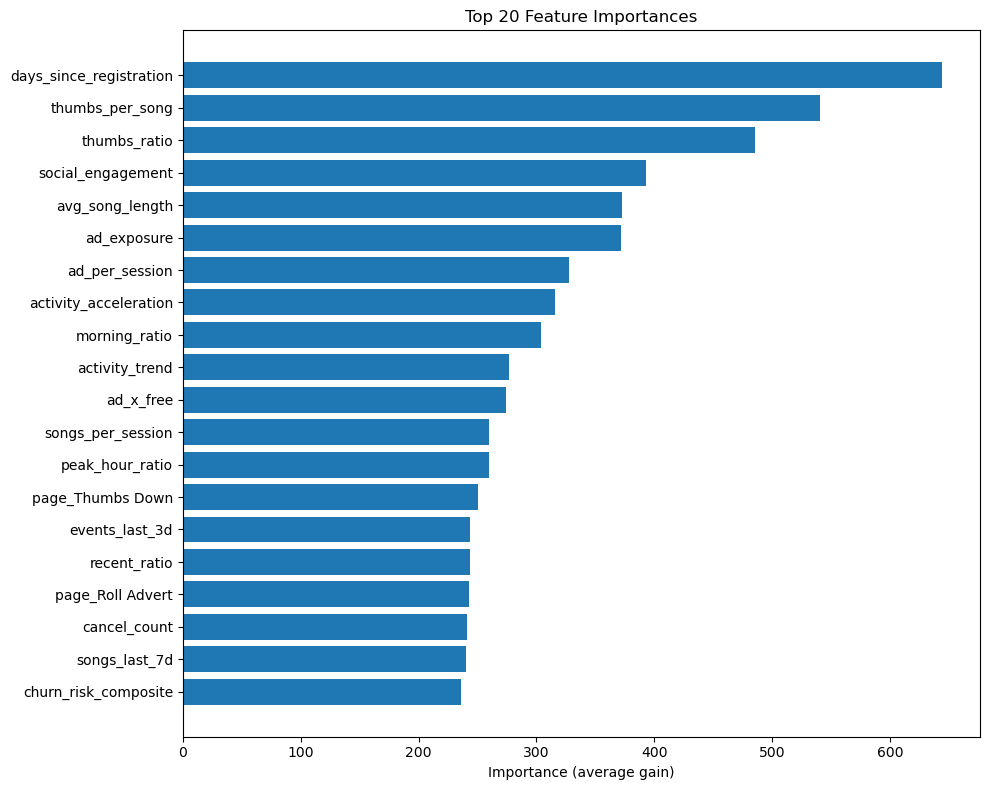

In [81]:
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel('Importance (average gain)')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()


## 6. Thresholding and Submission

To convert predicted probabilities into binary labels, we use percentile-based thresholding. Rather than selecting an arbitrary probability threshold (e.g., 0.5), we choose a threshold such that the predicted churn rate approximately matches expectations based on the training distribution. This approach is robust to miscalibration and does not require the model to output well-calibrated probabilities.

We generate submissions at several percentile thresholds around the 50th percentile to allow for fine-tuning based on leaderboard feedback.


In [83]:
def make_submission(preds, user_ids, percentile, filename):
    """
    Create submission file using percentile-based thresholding.
    """
    threshold = np.percentile(preds, percentile)
    labels = (preds >= threshold).astype(int)
    
    submission = pd.DataFrame({
        'id': user_ids,
        'target': labels
    })
    
    submission.to_csv(filename, index=False)
    churn_rate = labels.mean() * 100
    
    return submission, threshold, churn_rate


In [84]:
# Generate submissions at different percentile thresholds
print('Test predictions: min={:.4f}, max={:.4f}, mean={:.4f}'.format(
    test_preds.min(), test_preds.max(), test_preds.mean()))
print()

percentiles = [49.5, 50.0, 50.5]
for p in percentiles:
    sub, thresh, rate = make_submission(test_preds, test_user_ids, p, 'submission_p{}.csv'.format(int(p * 10)))
    print('Percentile {}: threshold={:.4f}, predicted churn rate={:.2f}%'.format(p, thresh, rate))


Test predictions: min=0.0054, max=0.7648, mean=0.1539

Percentile 49.5: threshold=0.1174, predicted churn rate=50.52%
Percentile 50.0: threshold=0.1194, predicted churn rate=50.00%
Percentile 50.5: threshold=0.1205, predicted churn rate=49.48%


In [85]:
# Primary submission at 50th percentile
submission, threshold, churn_rate = make_submission(test_preds, test_user_ids, 50.0, 'submission.csv')
print('Primary submission saved to submission.csv')
print('Threshold: {:.4f}'.format(threshold))
print('Predicted churn rate: {:.2f}%'.format(churn_rate))
submission.head(10)


Primary submission saved to submission.csv
Threshold: 0.1194
Predicted churn rate: 50.00%


,id,target
0,1000655,0
1,1000963,1
2,1001129,1
3,1001963,1
4,1002283,1
5,1002397,0
6,1002533,1
7,1002712,1
8,1002879,1
9,1003703,0
